# <center> Brief EDA into the JSON objects produced for each condition <center>

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setup Path
DATA_DIR = Path("../data")

all_summary = []
all_turns = []

# Load all 11 conditions
for i in range(1, 12):
    file_path = DATA_DIR / f"eval_results_cond_{i}.json"
    with open(file_path, "r") as f:
        data = json.load(f)
        
        # Summary Level
        all_summary.append({
            "id": data["metadata"]["id"],
            "name": data["metadata"]["name"],
            "accuracy": data["accuracy"],
            "scale_errors": data["metrics"]["scale_errors"]
        })
        
        # Turn Level (for decay analysis)
        for result in data["detailed_results"]:
            all_turns.append({
                "condition": data["metadata"]["name"],
                "turn": result["turn_index"],
                "is_correct": result["is_correct"]
            })

df_summary = pd.DataFrame(all_summary)
df_turns = pd.DataFrame(all_turns)

# Add logic categories for grouped plotting
def categorize(name):
    if "Baseline" in name: return "Baseline"
    if "Modular" in name: return "Planner/Analyst"
    return "Reflective"

df_summary['Category'] = df_summary['name'].apply(categorize)

# Tomoro-inspired Styling
TOMORO_DARK = "#1A1A1A"
TOMORO_TEAL = "#20C997"
TOMORO_SLATE = "#495057"
TOMORO_BLUE = "#007BFF"

plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#CCCCCC",
    "font.sans-serif": "Arial",
    "text.color": TOMORO_DARK,
    "axes.labelcolor": TOMORO_DARK,
    "xtick.color": TOMORO_DARK,
    "ytick.color": TOMORO_DARK
})

# 1. Setup Colors & Data Logic
TOMORO_BG = "#061728"
TOMORO_INDICATOR = "#9ab7d0"
TOMORO_WHITE = "#FFFFFF"

tier_colors = {
    "gpt-5-mini": "#629fa5",               # Brand Teal
    "gpt-5.2 (Medium Thinking)": "#4b7fff", # Brand Light Blue
    "gpt-5.2 (High Thinking)": "#d8ff00"    # Brand Highlighter
}

# Assign Tiers and specific X-coordinates with gaps
# Group 1: 0,1,2,3,4 | Gap | Group 2: 6,7,8 | Gap | Group 3: 10,11,12
x_coords = [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12]

def assign_tier(name):
    n = name.lower()
    if "mini" in n: return "gpt-5-mini"
    if "med" in n: return "gpt-5.2 (Medium Thinking)"
    if "high" in n or "reflective" in n or "reflect" in n: return "gpt-5.2 (High Thinking)"
    return "gpt-5-mini"

df_summary['Tier'] = df_summary['name'].apply(assign_tier)
df_summary['x'] = x_coords
colors = [tier_colors[t] for t in df_summary['Tier']]

# Mapping data from your table into the dataframe
recovery_map = {
    "9. Reflect (Mini)": {"attempts": 19, "successes": 13},
    "10. Reflect (Med)": {"attempts": 9, "successes": 3},
    "11. Reflect (High)": {"attempts": 12, "successes": 5}
}

df_summary['hallucinations'] = [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
df_summary['recovery_attempts'] = df_summary['name'].apply(lambda x: recovery_map.get(x, {}).get('attempts', 0))
df_summary['successful_recoveries'] = df_summary['name'].apply(lambda x: recovery_map.get(x, {}).get('successes', 0))
df_summary['recovery_rate'] = (df_summary['successful_recoveries'] / df_summary['recovery_attempts']).fillna(0) * 100

# Calculate accuracy per turn per condition
decay_df = df_turns.groupby(['condition', 'turn'])['is_correct'].mean().reset_index()
decay_df['accuracy'] = decay_df['is_correct'] * 100

## Initial EDA on the results, why did condition 11 perform so poorly? Why was condition 1 the best? 

In [36]:
df_summary

,id,name,accuracy,scale_errors,Category,Tier,x,hallucinations,recovery_attempts,successful_recoveries,recovery_rate
0,1,1. JSON Baseline (Mini),82.54,5,Baseline,gpt-5-mini,0,0,0,0,0.000000
1,2,2. MD Baseline (Mini),79.37,7,Baseline,gpt-5-mini,1,0,0,0,0.000000
2,3,3. JSON Baseline (Med),71.43,10,Baseline,gpt-5.2 (Medium Thinking),2,0,0,0,0.000000
3,4,4. MD Baseline (Med),71.43,12,Baseline,gpt-5.2 (Medium Thinking),3,0,0,0,0.000000
4,5,5. MD Baseline (High),76.19,8,Baseline,gpt-5.2 (High Thinking),4,1,0,0,0.000000
5,6,6. Modular (Mini),63.49,16,Modular,gpt-5-mini,6,0,0,0,0.000000
6,7,7. Modular (Med),76.19,9,Modular,gpt-5.2 (Medium Thinking),7,0,0,0,0.000000
7,8,8. Modular (High),77.78,8,Modular,gpt-5.2 (High Thinking),8,1,0,0,0.000000
8,9,9. Reflect (Mini),74.60,8,Reflective,gpt-5-mini,10,0,19,13,68.421053
9,10,10. Reflect (Med),74.60,8,Reflective,gpt-5.2 (Medium Thinking),11,1,9,3,33.333333


In [3]:
df_turns

,condition,turn,is_correct
0,1. JSON Baseline (Mini),0,True
1,1. JSON Baseline (Mini),1,True
2,1. JSON Baseline (Mini),2,True
3,1. JSON Baseline (Mini),3,True
4,1. JSON Baseline (Mini),0,False
...,...,...,...
688,11. Reflect (High),0,False
689,11. Reflect (High),1,False
690,11. Reflect (High),2,False
691,11. Reflect (High),0,True


In [5]:
# 1. Grouped Analysis by Tier
tier_stats = df_summary.groupby('Tier').agg({
    'accuracy': ['mean', 'std'],
    'recovery_rate': 'mean',
    'scale_errors': 'sum'
}).round(2)

# 2. Turn-based Decay (Turn Index vs Correctness)
turn_decay = df_turns.groupby('turn')['is_correct'].mean()

# 3. Reflection Efficiency 
# (How many attempts actually lead to a success?)
df_summary['recovery_efficiency'] = df_summary['successful_recoveries'] / df_summary['recovery_attempts']

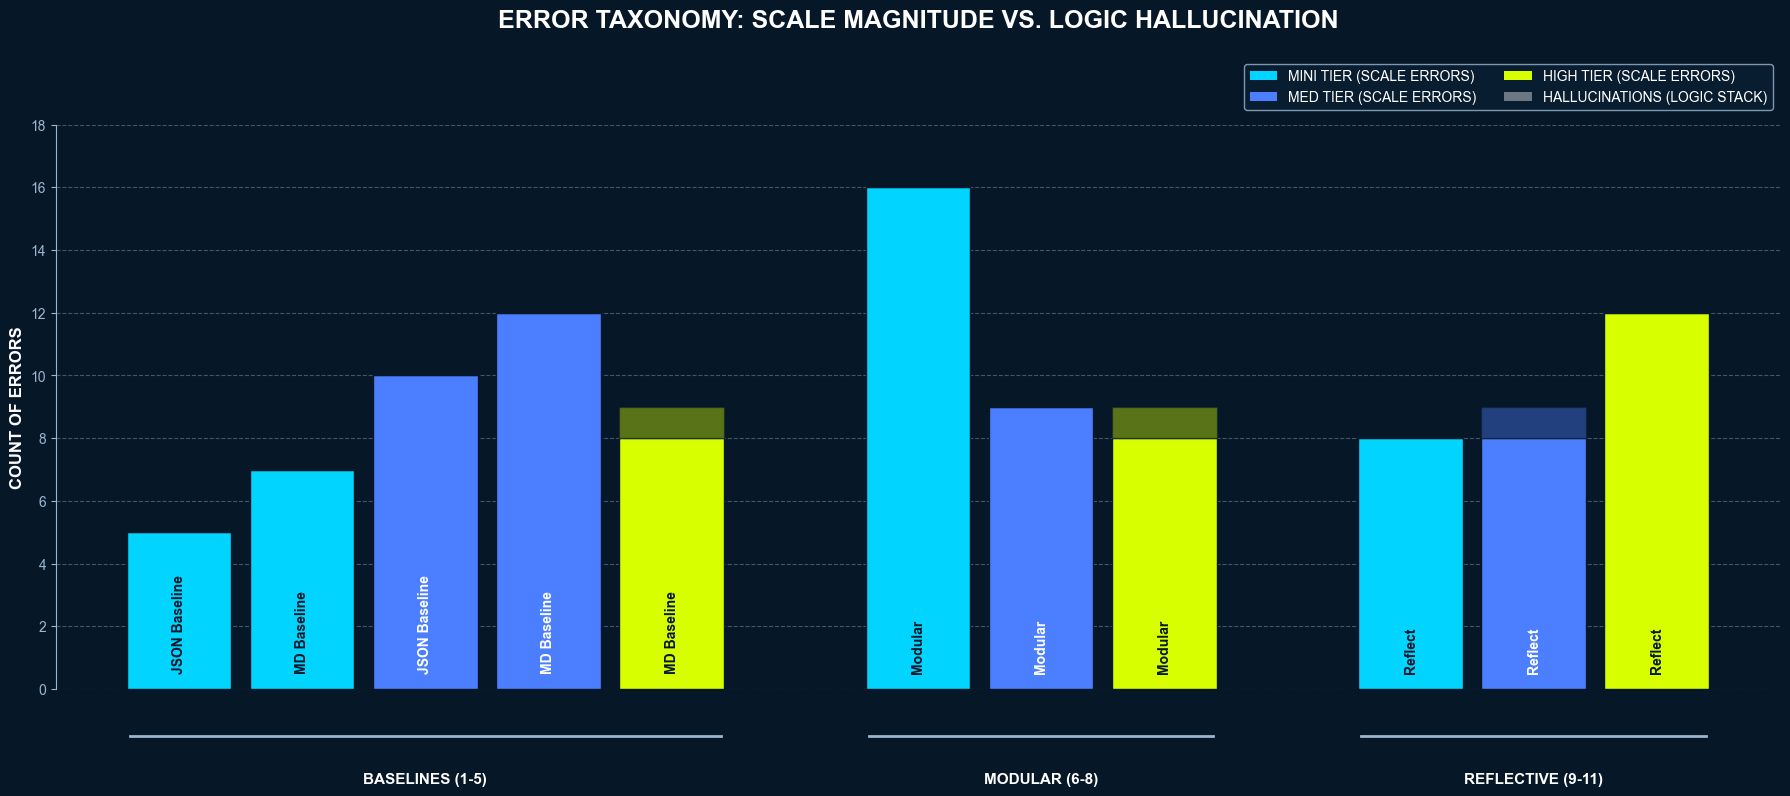

In [51]:
from matplotlib.patches import Patch

# 1. Color Mapping
color_map = {
    "Mini": "#00d4ff", # Cyan
    "Med":  "#4b7fff", # Blue
    "High": "#d8ff00"  # Yellow/Green
}

# Generate base color list
bar_colors = []
for name in df_summary['name']:
    if "Mini" in name: bar_colors.append(color_map["Mini"])
    elif "Med" in name: bar_colors.append(color_map["Med"])
    elif "High" in name: bar_colors.append(color_map["High"])
    else: bar_colors.append(TOMORO_INDICATOR)

# Apply Global Styling
plt.rcParams.update({
    "figure.facecolor": TOMORO_BG, "axes.facecolor": TOMORO_BG,
    "axes.edgecolor": TOMORO_INDICATOR, "text.color": TOMORO_WHITE,
    "axes.labelcolor": TOMORO_WHITE, "xtick.color": TOMORO_INDICATOR,
    "ytick.color": TOMORO_INDICATOR, "font.sans-serif": "Arial"
})

fig, ax = plt.subplots(figsize=(18, 9))
x = df_summary['x'] 
width = 0.85

# 2. Plotting Stacked Bars
# Bottom Bar: Solid Color
p1 = ax.bar(x, df_summary['scale_errors'], width, color=bar_colors, edgecolor=TOMORO_BG)

# Top Bar: Same colors as p1, but with alpha=0.4 to make them "ghost" bars
p2 = ax.bar(x, df_summary['hallucinations'], width, bottom=df_summary['scale_errors'], 
            color=bar_colors, alpha=0.4, edgecolor=TOMORO_BG)

# High Contrast Grid
ax.yaxis.grid(True, linestyle='--', color=TOMORO_INDICATOR, alpha=0.4)
ax.set_axisbelow(True)

# 3. Add Group Annotations (Brackets)
groups = [("BASELINES (1-5)", 0, 4), ("MODULAR (6-8)", 6, 8), ("REFLECTIVE (9-11)", 10, 12)]
for label, start, end in groups:
    y_line, y_text = -1.5, -3 
    ax.plot([start-0.4, end+0.4], [y_line, y_line], color=TOMORO_INDICATOR, lw=2, clip_on=False)
    ax.text((start + end) / 2, y_text, label, ha='center', weight='bold', fontsize=11, clip_on=False)

# 4. Internal Bar Labels
for i, bar in enumerate(p1):
    full_name = df_summary.iloc[i]['name']
    label = full_name.split(". ")[1].split(" (")[0] if ". " in full_name else full_name
    text_col = TOMORO_BG if ("Mini" in full_name or "High" in full_name) else TOMORO_WHITE
    ax.text(bar.get_x() + bar.get_width()/2, 0.5, label, ha='center', va='bottom', 
            rotation=90, color=text_col, weight='bold', fontsize=10)

# Formatting
plt.title("ERROR TAXONOMY: SCALE MAGNITUDE VS. LOGIC HALLUCINATION", fontsize=18, pad=70, weight='bold')
plt.ylabel("COUNT OF ERRORS", fontsize=12, weight='bold')
plt.xticks([])
plt.xlim(-1, 13)
plt.ylim(0, 18)

# 5. Custom Legend with Alpha-matching
legend_elements = [
    Patch(facecolor=color_map["Mini"], label='MINI TIER (SCALE ERRORS)'),
    Patch(facecolor=color_map["Med"], label='MED TIER (SCALE ERRORS)'),
    Patch(facecolor=color_map["High"], label='HIGH TIER (SCALE ERRORS)'),
    # This patch uses a neutral gray with alpha to show the "type" of the stack
    Patch(facecolor=TOMORO_WHITE, alpha=0.4, label='HALLUCINATIONS (LOGIC STACK)')
]

leg = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1.12), ncol=2, frameon=True)
leg.get_frame().set_facecolor("#0a1f33")
leg.get_frame().set_edgecolor(TOMORO_INDICATOR)

for spine in ['top', 'right', 'bottom']: ax.spines[spine].set_visible(False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

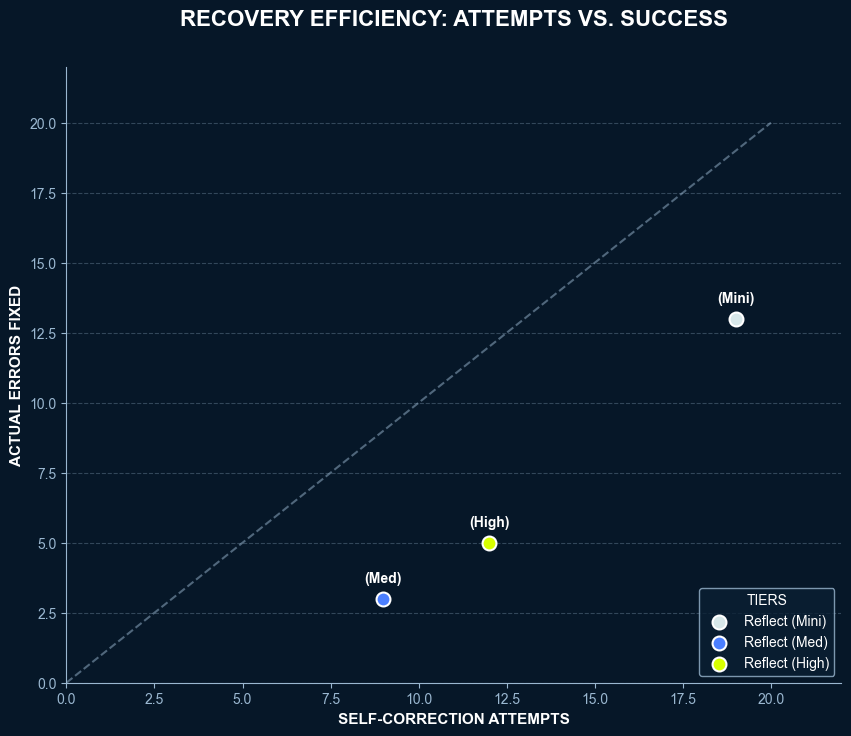

In [20]:
# Data from your table for Reflective models (9, 10, 11)
recovery_stats = pd.DataFrame({
    "Condition": ["Reflect (Mini)", "Reflect (Med)", "Reflect (High)"],
    "Attempts": [19, 9, 12],
    "Successes": [13, 3, 5],
    "Color": ["#d7e7e9", "#4b7fff", "#d8ff00"]
})

# Change the size here (s=400 is a good standard size)
node_size = 100 

fig, ax = plt.subplots(figsize=(10, 8))

# Add 45-degree line
ax.plot([0, 20], [0, 20], linestyle='--', color=TOMORO_INDICATOR, alpha=0.5, zorder=1)

# Scatter Plot
for i, row in recovery_stats.iterrows():
    # Reduced s from 1200 to 400
    ax.scatter(row['Attempts'], row['Successes'], s=node_size, color=row['Color'], 
               edgecolor=TOMORO_WHITE, linewidth=1.5, label=row['Condition'], zorder=3)
    
    # Adjusting text: moved it slightly above the point (va='bottom') 
    # and changed color to TOMORO_WHITE so it's readable outside the bubble
    ax.text(row['Attempts'], row['Successes'] + 0.5, row['Condition'].split(" ")[1], 
            ha='center', va='bottom', color=TOMORO_WHITE, weight='bold', fontsize=10)

# Formatting (rest of your code remains the same)
plt.title("RECOVERY EFFICIENCY: ATTEMPTS VS. SUCCESS", fontsize=16, pad=30, weight='bold')
plt.xlabel("SELF-CORRECTION ATTEMPTS", fontsize=11, weight='bold')
plt.ylabel("ACTUAL ERRORS FIXED", fontsize=11, weight='bold')

ax.yaxis.grid(True, linestyle='--', color=TOMORO_INDICATOR, alpha=0.3)
ax.set_facecolor(TOMORO_BG)
ax.set_xlim(0, 22)
ax.set_ylim(0, 22)

# Custom Legend
leg = ax.legend(title="TIERS", loc='lower right', frameon=True)
leg.get_frame().set_facecolor("#0a1f33")
leg.get_frame().set_edgecolor(TOMORO_INDICATOR)

for spine in ['top', 'right']: ax.spines[spine].set_visible(False)
plt.show()

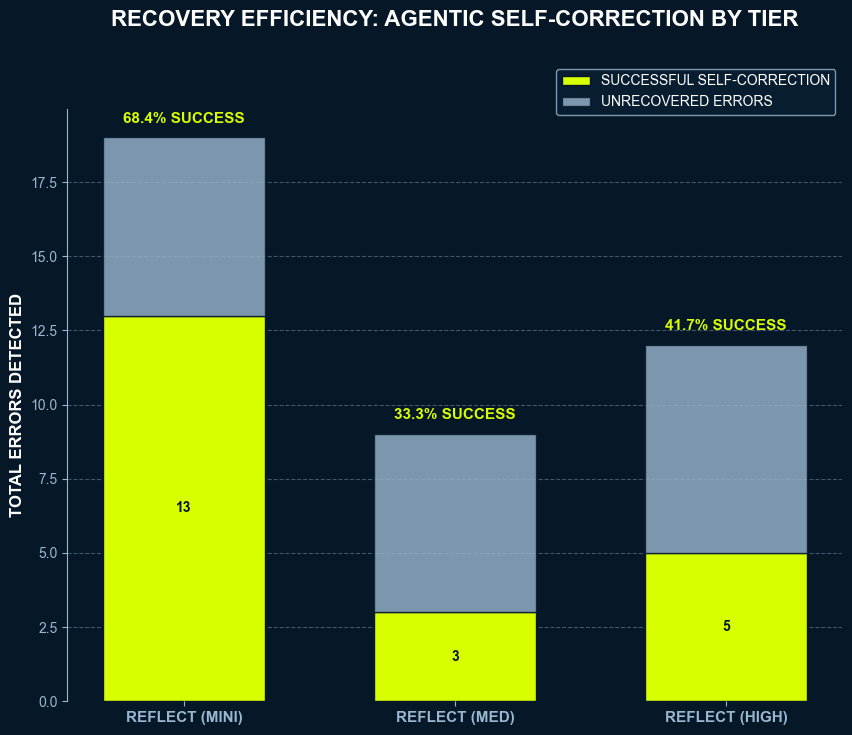

In [34]:
# Filter for Reflective Tier
reflect_df = df_summary[df_summary['Category'] == 'Reflective'].copy()
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare Data
reflect_df['unrecovered_errors'] = reflect_df['recovery_attempts'] - reflect_df['successful_recoveries']

# Ensure global styling is applied (re-applying to be safe)
plt.rcParams.update({
    "figure.facecolor": TOMORO_BG,
    "axes.facecolor": TOMORO_BG,
    "axes.edgecolor": TOMORO_INDICATOR,
    "text.color": TOMORO_WHITE,
    "axes.labelcolor": TOMORO_WHITE,
    "xtick.color": TOMORO_INDICATOR,
    "ytick.color": TOMORO_INDICATOR
})

fig, ax = plt.subplots(figsize=(10, 8))

x_indices = np.arange(len(reflect_df))
width = 0.6 

# 2. Plotting the Stacked Bars
ax.bar(x_indices, reflect_df['successful_recoveries'], width, 
       color="#d8ff00", label='SUCCESSFUL SELF-CORRECTION', edgecolor=TOMORO_BG)

ax.bar(x_indices, reflect_df['unrecovered_errors'], width, 
       bottom=reflect_df['successful_recoveries'],
       color=TOMORO_INDICATOR, alpha=0.8, label='UNRECOVERED ERRORS', edgecolor=TOMORO_BG)

# 3. Styling & Grid
ax.yaxis.grid(True, linestyle='--', color=TOMORO_INDICATOR, alpha=0.4)
ax.set_axisbelow(True)

# 4. Labels and Percentages
plt.xticks(x_indices, ["REFLECT (MINI)", "REFLECT (MED)", "REFLECT (HIGH)"], weight='bold', fontsize=11)

# INCREASED PAD TO 60 TO PREVENT OVERLAP
plt.title("RECOVERY EFFICIENCY: AGENTIC SELF-CORRECTION BY TIER", 
          fontsize=16, pad=60, weight='bold')

plt.ylabel("TOTAL ERRORS DETECTED", fontsize=12, weight='bold')

# Add Annotations
for i in range(len(reflect_df)):
    success_val = reflect_df['successful_recoveries'].iloc[i]
    total_val = reflect_df['recovery_attempts'].iloc[i]
    rate = reflect_df['recovery_rate'].iloc[i]
    
    # Success % Label
    ax.text(i, total_val + 0.5, f"{rate:.1f}% SUCCESS", 
            ha='center', weight='bold', color="#d8ff00", fontsize=11)
    
    # Count inside the bar
    if success_val > 0:
        ax.text(i, success_val / 2, f"{int(success_val)}", 
                ha='center', va='center', weight='bold', color=TOMORO_BG)

# 5. Legend (Adjusted to match Gold Standard 1.08)
leg = ax.legend(loc='upper right', frameon=True, bbox_to_anchor=(1, 1.08), ncol=1)
leg.get_frame().set_facecolor("#0a1f33")
leg.get_frame().set_edgecolor(TOMORO_INDICATOR)

# 6. Final Polish
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)

# Explicitly adjust the top margin to accommodate the title and legend
plt.subplots_adjust(top=0.85) 
plt.show()

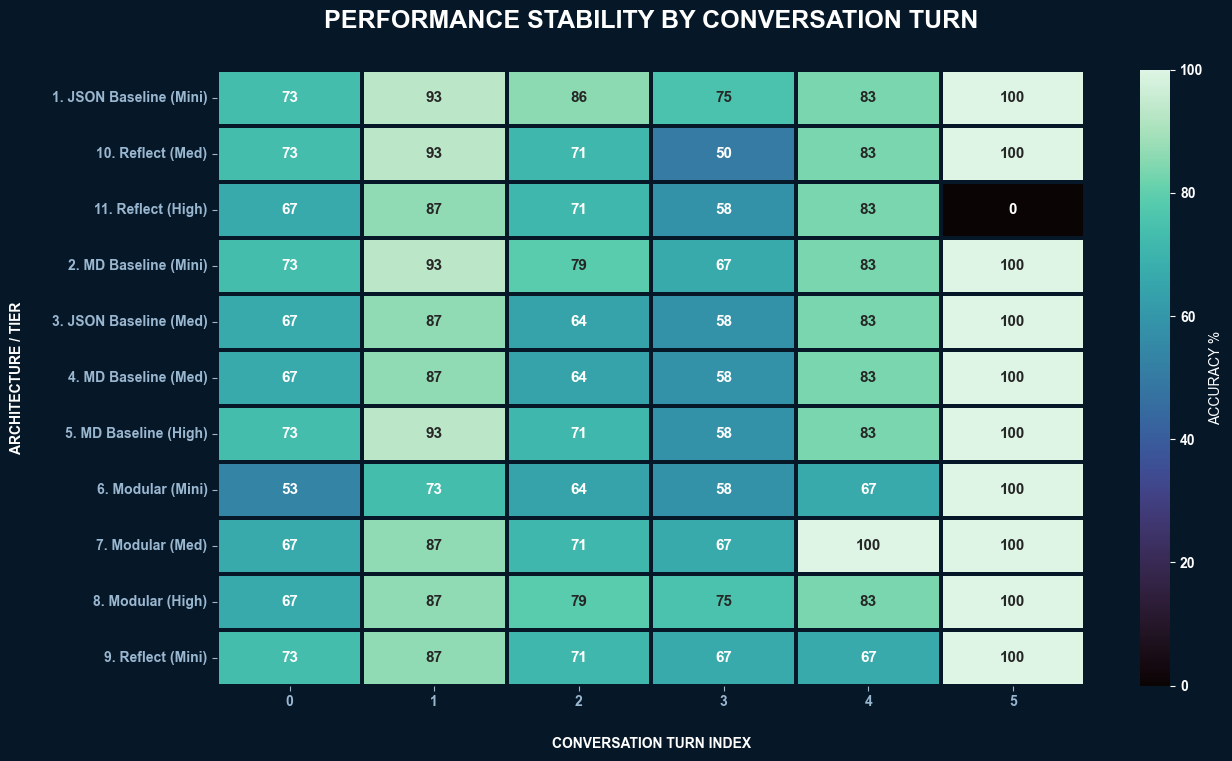

In [23]:
# Pivot turn data
heatmap_data = df_turns.groupby(['condition', 'turn'])['is_correct'].mean().unstack() * 100

plt.figure(figsize=(14, 8))
# Custom colormap that starts from the background color
cmap = sns.dark_palette(TOMORO_INDICATOR, as_cmap=True) 

ax = sns.heatmap(heatmap_data, annot=True, cmap="mako", fmt=".0f", 
                linewidths=1.5, linecolor=TOMORO_BG,
                cbar_kws={'label': 'ACCURACY %'},
                annot_kws={"weight": "bold", "fontsize": 11})

# Formatting
plt.title("PERFORMANCE STABILITY BY CONVERSATION TURN", fontsize=18, pad=30, weight='bold', color=TOMORO_WHITE)
plt.ylabel("ARCHITECTURE / TIER", weight='bold', labelpad=20)
plt.xlabel("CONVERSATION TURN INDEX", weight='bold', labelpad=20)

# Style the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10, color=TOMORO_WHITE)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=TOMORO_WHITE, weight='bold')

plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

In [9]:
# 1. Category Performance (Are we actually improving with complexity?)
category_analysis = df_summary.groupby('Category')['accuracy'].agg(['mean', 'std', 'max']).round(2)
print("--- Category Performance ---")
print(category_analysis)

# 2. Tier Performance (Does 'Thinking' pay off?)
tier_analysis = df_summary.groupby('Tier')['accuracy'].mean().sort_values(ascending=False)
print("\n--- Tier Performance ---")
print(tier_analysis)

# 3. Correlation: Errors vs Accuracy
# Is Scale Error the primary driver of failure?
correlation = df_summary['accuracy'].corr(df_summary['scale_errors'])
print(f"\nCorrelation between Scale Errors and Accuracy: {correlation:.2f}")

--- Category Performance ---
             mean   std    max
Category                      
Baseline    76.19  4.89  82.54
Modular     72.49  7.83  77.78
Reflective  73.54  1.83  74.60

--- Tier Performance ---
Tier
gpt-5.2 (High Thinking)      75.133333
gpt-5-mini                   75.000000
gpt-5.2 (Medium Thinking)    73.412500
Name: accuracy, dtype: float64

Correlation between Scale Errors and Accuracy: -0.96


In [35]:

# --- 1. DATA FOR: ERROR TAXONOMY (Stacked Bar) ---
print("TABLE 1: ERROR TAXONOMY DATA")
print("-" * 30)
# Selecting the columns used in the first plot
taxonomy_table = df_summary[['name', 'scale_errors', 'hallucinations']].copy()
taxonomy_table['total_errors'] = taxonomy_table['scale_errors'] + taxonomy_table['hallucinations']
print(taxonomy_table.to_string(index=False))
print("\n")


# --- 2. DATA FOR: RECOVERY EFFICIENCY (Scatter Plot) ---
print("TABLE 2: RECOVERY EFFICIENCY (SCATTER) DATA")
print("-" * 30)
# This uses the recovery_stats dataframe created in your scatter snippet
print(recovery_stats[['Condition', 'Attempts', 'Successes']].to_string(index=False))
print("\n")


# --- 3. DATA FOR: PERFORMANCE STABILITY (Heatmap) ---
print("TABLE 3: PERFORMANCE STABILITY (HEATMAP %)")
print("-" * 30)
# This recreates the pivot table logic used in the heatmap
heatmap_table = df_turns.groupby(['condition', 'turn'])['is_correct'].mean().unstack() * 100
print(heatmap_table.round(1).to_string())
print("\n")


# --- 4. DATA FOR: AGENTIC SELF-CORRECTION (Reflective Tier) ---
print("TABLE 4: AGENTIC SELF-CORRECTION DATA")
print("-" * 30)
# Preparing the calculated columns used in the final bar chart
reflect_export = reflect_df.copy()
reflect_export['unrecovered_errors'] = reflect_export['recovery_attempts'] - reflect_export['successful_recoveries']
reflect_export = reflect_export[['name', 'successful_recoveries', 'unrecovered_errors', 'recovery_attempts', 'recovery_rate']]

# Renaming for clarity in the printout
reflect_export.columns = ['Model', 'Successes', 'Unrecovered', 'Total Attempts', 'Success Rate %']
print(reflect_export.to_string(index=False))

TABLE 1: ERROR TAXONOMY DATA
------------------------------
                   name  scale_errors  hallucinations  total_errors
1. JSON Baseline (Mini)             5               0             5
  2. MD Baseline (Mini)             7               0             7
 3. JSON Baseline (Med)            10               0            10
   4. MD Baseline (Med)            12               0            12
  5. MD Baseline (High)             8               1             9
      6. Modular (Mini)            16               0            16
       7. Modular (Med)             9               0             9
      8. Modular (High)             8               1             9
      9. Reflect (Mini)             8               0             8
      10. Reflect (Med)             8               1             9
     11. Reflect (High)            12               0            12


TABLE 2: RECOVERY EFFICIENCY (SCATTER) DATA
------------------------------
     Condition  Attempts  Successes
Reflect (Mi

---

### Cell 2: Viz A — The Performance Staircase
This chart shows how different models perform across the three architectural tiers. It highlights the "Mini Paradox" (high baseline, low modularity).

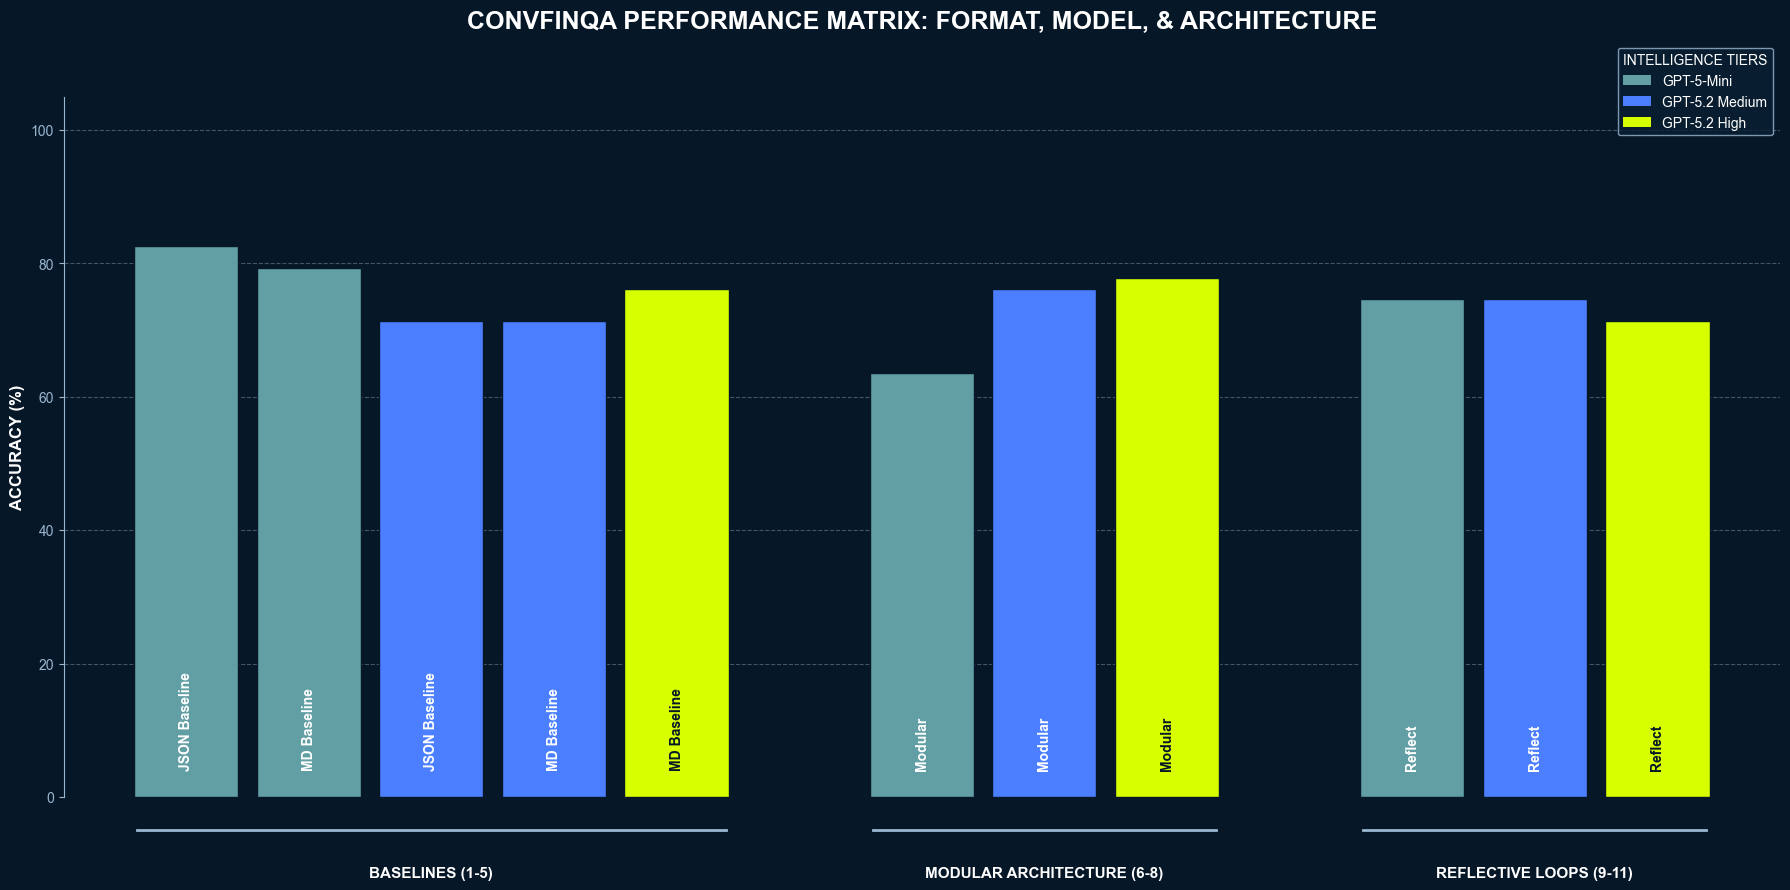

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch


# 2. Setup Styling
plt.rcParams.update({
    "figure.facecolor": TOMORO_BG,
    "axes.facecolor": TOMORO_BG,
    "axes.edgecolor": TOMORO_INDICATOR,
    "text.color": TOMORO_WHITE,
    "axes.labelcolor": TOMORO_WHITE,
    "xtick.color": TOMORO_INDICATOR,
    "ytick.color": TOMORO_INDICATOR,
    "font.sans-serif": "Arial"
})

fig, ax = plt.subplots(figsize=(18, 9))

# 3. Plotting using plt.bar (This respects numerical spacing/gaps)
bars = ax.bar(
    df_summary['x'], 
    df_summary['accuracy'], 
    color=colors,
    edgecolor=TOMORO_BG,
    linewidth=1,
    width=0.85  # Slightly thinner bars look better with gaps
)

# 4. HIGH CONTRAST GRID
ax.yaxis.grid(True, linestyle='--', color=TOMORO_INDICATOR, alpha=0.4)
ax.set_axisbelow(True)

# 5. Add Group Annotations (Brackets & Labels)
# Note: y_pos is negative to sit below the chart
groups = [
    ("BASELINES (1-5)", 0, 4),
    ("MODULAR ARCHITECTURE (6-8)", 6, 8),
    ("REFLECTIVE LOOPS (9-11)", 10, 12)
]

for label, start, end in groups:
    y_line = -5
    y_text = -12
    # Draw the horizontal separator line
    ax.plot([start-0.4, end+0.4], [y_line, y_line], color=TOMORO_INDICATOR, lw=2, clip_on=False)
    # Group label text
    ax.text((start + end) / 2, y_text, label, ha='center', weight='bold', fontsize=11, clip_on=False)

# 6. Internal Bar Labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        full_name = df_summary.iloc[i]['name']
        # Clean up label: "1. JSON Baseline (Mini)" -> "JSON Baseline"
        try:
            label = full_name.split(". ")[1].split(" (")[0]
        except:
            label = full_name
            
        # Color logic: Black text for the bright highlighter yellow
        tier = df_summary.iloc[i]['Tier']
        text_col = TOMORO_BG if tier == "gpt-5.2 (High Thinking)" else TOMORO_WHITE
        
        ax.text(
            bar.get_x() + bar.get_width()/2, 
            4, # Position 4% from the bottom
            label,
            ha='center', va='bottom', rotation=90,
            color=text_col, weight='bold', fontsize=10
        )

# Formatting
plt.title("CONVFINQA PERFORMANCE MATRIX: FORMAT, MODEL, & ARCHITECTURE", 
          fontsize=18, pad=50, weight='bold')
plt.ylabel("ACCURACY (%)", fontsize=12, weight='bold')
plt.xticks([]) # Hide standard ticks
plt.xlim(-1, 13)
plt.ylim(0, 105)

# 7. Custom Legend
legend_elements = [
    Patch(facecolor=tier_colors["gpt-5-mini"], label='GPT-5-Mini'),
    Patch(facecolor=tier_colors["gpt-5.2 (Medium Thinking)"], label='GPT-5.2 Medium'),
    Patch(facecolor=tier_colors["gpt-5.2 (High Thinking)"], label='GPT-5.2 High')
]
leg = ax.legend(handles=legend_elements, title="INTELLIGENCE TIERS", 
                 loc='upper right', frameon=True, bbox_to_anchor=(1, 1.08))
leg.get_frame().set_facecolor("#0a1f33")
leg.get_frame().set_edgecolor(TOMORO_INDICATOR)

# Clean up spines
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

---

### Cell 3: Viz B — Reasoning Decay Analysis
This is your "Intelligence Story." It shows that Turn 0 (Retrieval) is easy for everyone, but accuracy crashes as the math gets harder in later turns.

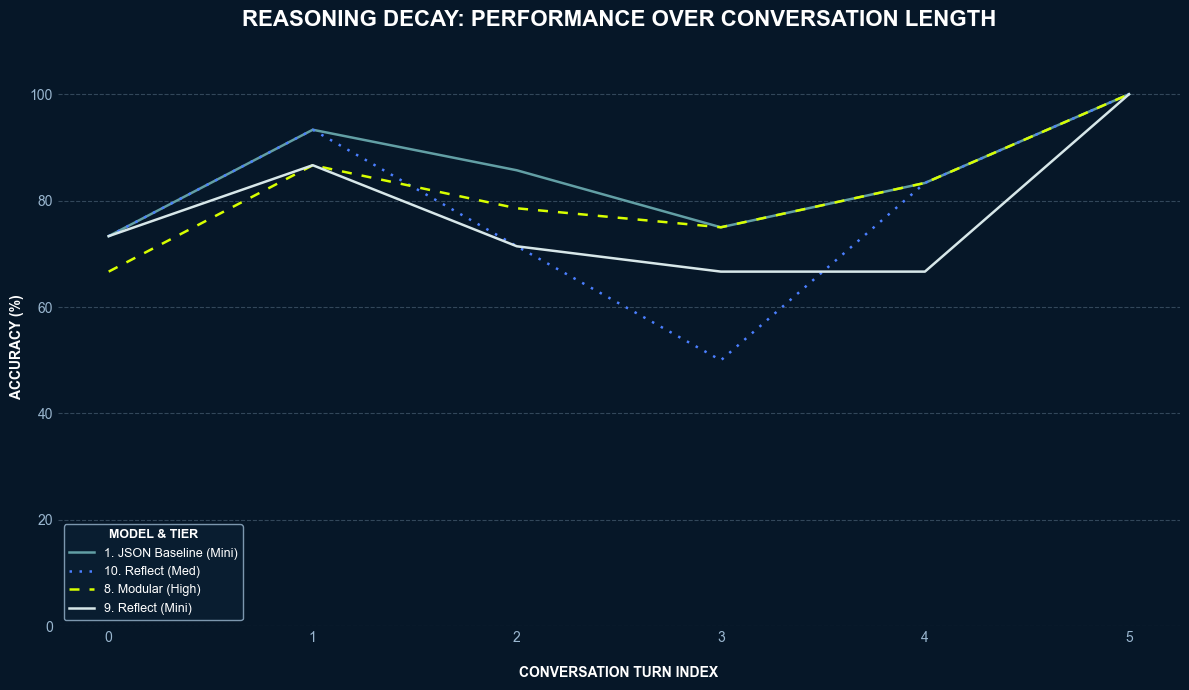

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Colors & Style Setup
TOMORO_BG = "#061728"
TOMORO_INDICATOR = "#9ab7d0"
TOMORO_WHITE = "#FFFFFF"
TOMORO_OFFWHITE = "#d7e7e9" 

condition_palette = {
    "1. JSON Baseline (Mini)": "#629fa5",   # Brand Teal
    "8. Modular (High)": "#d8ff00",        # Brand Highlighter
    "9. Reflect (Mini)": TOMORO_OFFWHITE,  # Off-White
    "10. Reflect (Med)": "#4b7fff"         # Brand Light Blue
}

# Define patterns based on TIERS
# Solid = "", Dashed = (4, 4), Dotted = (1, 3)
line_styles = {
    "1. JSON Baseline (Mini)": "",         
    "8. Modular (High)": (4, 4),           
    "9. Reflect (Mini)": "",               
    "10. Reflect (Med)": (1, 3)            
}

plt.rcParams.update({
    "figure.facecolor": TOMORO_BG,
    "axes.facecolor": TOMORO_BG,
    "axes.edgecolor": TOMORO_INDICATOR,
    "text.color": TOMORO_WHITE,
    "axes.labelcolor": TOMORO_WHITE,
    "xtick.color": TOMORO_INDICATOR,
    "ytick.color": TOMORO_INDICATOR,
    "font.sans-serif": "Arial"
})

plt.figure(figsize=(12, 7))

# 2. Plotting
ax = sns.lineplot(
    data=decay_df[decay_df['condition'].isin(condition_palette.keys())],
    x="turn", 
    y="accuracy", 
    hue="condition",
    style="condition",
    dashes=line_styles,
    markers=False,      # REMOVES THE DOTS/SQUARES ON THE NODES
    linewidth=1.8,      # SLIGHTLY THINNER LINE
    palette=condition_palette
)

# 3. High Contrast Grid
ax.yaxis.grid(True, linestyle='--', color=TOMORO_INDICATOR, alpha=0.3)
ax.set_axisbelow(True)

# 4. Remove Axis Ticks (The tiny lines on the frame)
ax.tick_params(axis='both', which='both', length=0) 

# 5. Formatting
plt.title("REASONING DECAY: PERFORMANCE OVER CONVERSATION LENGTH", 
          fontsize=16, pad=30, weight='bold')
plt.ylabel("ACCURACY (%)", fontsize=10, weight='bold')
plt.xlabel("CONVERSATION TURN INDEX", fontsize=10, weight='bold', labelpad=15)

plt.xticks([0, 1, 2, 3, 4, 5])
plt.ylim(0, 105)

# 6. Legend Styling
leg = plt.legend(title="MODEL & TIER", loc='lower left', frameon=True, fontsize=9)
leg.get_frame().set_facecolor("#0a1f33")
leg.get_frame().set_edgecolor(TOMORO_INDICATOR)
plt.setp(leg.get_title(), weight='bold', fontsize=9)

# Remove the visible frame spines for a cleaner "modern" look
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

---

### Cell 4: Viz C — The Agentic Recovery ROI
This bar chart shows the specific value-add of the Auditor. It isolates the delta between the "Crashing" Modular Mini and the "Saved" Reflective Mini.


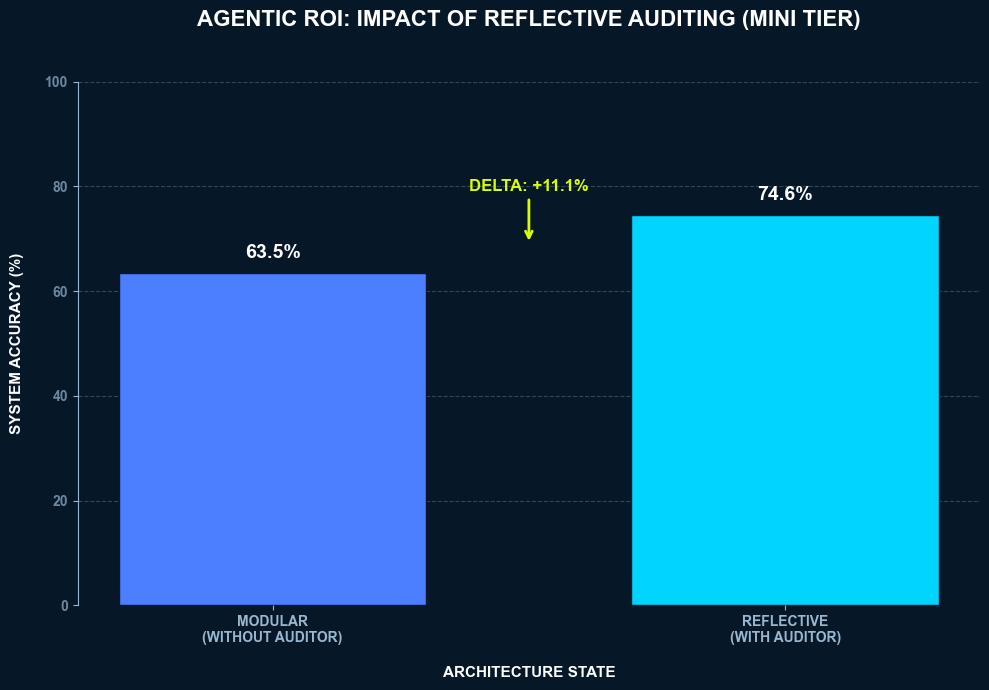

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Prepare Data & Calculate Delta
mini_mod = df_summary[df_summary['name'] == "6. Modular (Mini)"]['accuracy'].values[0]
mini_ref = df_summary[df_summary['name'] == "9. Reflect (Mini)"]['accuracy'].values[0]
delta = mini_ref - mini_mod

roi_data = pd.DataFrame({
    'State': ['MODULAR\n(WITHOUT AUDITOR)', 'REFLECTIVE\n(WITH AUDITOR)'],
    'Accuracy': [mini_mod, mini_ref]
})

# 2. Apply Global Styling
plt.rcParams.update({
    "figure.facecolor": TOMORO_BG,
    "axes.facecolor": TOMORO_BG,
    "axes.edgecolor": TOMORO_INDICATOR,
    "text.color": TOMORO_WHITE,
    "axes.labelcolor": TOMORO_WHITE,
    "font.sans-serif": "Arial"
})

fig, ax = plt.subplots(figsize=(10, 7))

# 3. Plotting
colors = ["#4b7fff", "#00d4ff"] # Med Blue to Mini Cyan
bars = ax.bar(roi_data['State'], roi_data['Accuracy'], color=colors, width=0.6, edgecolor=TOMORO_BG)

# 4. Styling & Grid
ax.yaxis.grid(True, linestyle='--', color=TOMORO_INDICATOR, alpha=0.3)
ax.set_axisbelow(True)

# 5. Annotations (Percentages & Delta)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{height:.1f}%', ha='center', va='bottom', 
            weight='bold', fontsize=14, color=TOMORO_WHITE)

# Add the Delta (Uplift) Annotation
ax.annotate(f'DELTA: +{delta:.1f}%', 
            xy=(0.5, (mini_mod + mini_ref) / 2), 
            xytext=(0.5, (mini_mod + mini_ref) / 2 + 10),
            ha='center', weight='bold', color="#d8ff00", # Success Yellow
            fontsize=12, arrowprops=dict(arrowstyle='->', color="#d8ff00", lw=2))

# 6. Formatting
plt.title("AGENTIC ROI: IMPACT OF REFLECTIVE AUDITING (MINI TIER)", 
          fontsize=16, pad=40, weight='bold')

plt.ylabel("SYSTEM ACCURACY (%)", fontsize=11, weight='bold', labelpad=15)
plt.xlabel("ARCHITECTURE STATE", fontsize=11, weight='bold', labelpad=15)

plt.ylim(0, 100)
plt.xticks(weight='bold', fontsize=10)
plt.yticks(weight='bold', alpha=0.7)

# Remove spines
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()



### Pro-Tip for the Notebook:
When you run these in the notebook, you can **Right-click the chart -> Save Image As**. Then, in your `report.md`, reference them like this:

```markdown
![Reasoning Decay Chart](./notebooks/reasoning_decay.png)
*Figure 2: Analysis of performance degradation across conversational turns.*
```

This will look extremely professional for your assessment!

Since standard Markdown doesn't support background colors or custom text hex-codes, the best way to maintain your "Branded" look is to use **Tier Indicators (Emojis)** and **Markdown Bold/Italic** formatting to group the architectures.

I have used colors that map to your tiers:
*   🟢 **Teal** (Mini)
*   🔵 **Blue** (Medium)
*   🟡 **Highlighter** (High)

### Ablation Study: Comparative Performance

| Tier | Condition | Accuracy | Hallucinations | Scale Errors | Recovery Rate |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Baselines** | | | | | |
| 🟢 | 1. JSON Baseline (Mini) | **82.54%** | 0 | 5 | 0.0% |
| 🟢 | 2. MD Baseline (Mini) | 79.37% | 0 | 7 | 0.0% |
| 🔵 | 3. JSON Baseline (Med) | 71.43% | 0 | 10 | 0.0% |
| 🔵 | 4. MD Baseline (Med) | 71.43% | 0 | 12 | 0.0% |
| 🟡 | 5. MD Baseline (High) | 76.19% | 1 | 8 | 0.0% |
| **Planner/Analyst (Modular)** | | | | | |
| 🟢 | 6. Modular (Mini) | 63.49% | 0 | 16 | 0.0% |
| 🔵 | 7. Modular (Med) | 76.19% | 0 | 9 | 0.0% |
| 🟡 | 8. Modular (High) | **77.78%** | 1 | 8 | 0.0% |
| **Planner/Analyst/Reviewer (Rreflective)** | | | | | |
| 🟢 | 9. Reflect (Mini) | 74.60% | 0 | 8 | **68.4%** |
| 🔵 | 10. Reflect (Med) | 74.60% | 1 | 8 | 33.3% |
| 🟡 | 11. Reflect (High) | 71.43% | 0 | 12 | 41.7% |

***

### Key Takeaways
*   **Best Accuracy:** `1. JSON Baseline (Mini)` at **82.54%**.
*   **Best Error Correction:** `9. Reflect (Mini)` with a **68.4% recovery rate**, successfully catching errors that other architectures missed.
*   **Scale Errors:** Modular and Reflective architectures generally showed lower scale errors than Medium-tier baselines.